# Project Solution
Bryan Herman

In [114]:
import diffusion
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Define all materials

In [2]:
fuel_low = diffusion.Material(num_energy_groups=2)
fuel_low.diffusion = [1.268, 0.1902]
fuel_low.total = [0.064851, 0.17047]
fuel_low.scattering = [[0.03, 0.02767], [0.0, 0.1]]
fuel_low.nu_fission = [0.004609, 0.08675]
fuel_low.chi = [1.0, 0.0]

fuel_low_rod = diffusion.Material(num_energy_groups=2)
fuel_low_rod.diffusion = [1.255, 0.211]
fuel_low_rod.total = [0.063582, 0.2003]
fuel_low_rod.scattering = [[0.03, 0.02533], [0.0, 0.1]]
fuel_low_rod.nu_fission = [0.004602, 0.1091]
fuel_low_rod.chi = [1.0, 0.0]

fuel_high = diffusion.Material(num_energy_groups=2)
fuel_high.diffusion = [1.259, 0.2091]
fuel_high.total = [0.064171, 0.173324]
fuel_high.scattering = [[0.03, 0.02617], [0.0, 0.1]]
fuel_high.nu_fission = [0.004663, 0.1021]
fuel_high.chi = [1.0, 0.0]

fuel_high_rod = diffusion.Material(num_energy_groups=2)
fuel_high_rod.diffusion = [1.259, 0.2091]
fuel_high_rod.total = [0.064171, 0.18344]
fuel_high_rod.scattering = [[0.03, 0.02617], [0.0, 0.1]]
fuel_high_rod.nu_fission = [0.004663, 0.1021]
fuel_high_rod.chi = [1.0, 0.0]

reflector = diffusion.Material(num_energy_groups=2)
reflector.diffusion = [1.257, 0.1592]
reflector.total = [0.0781434, 0.11911]
reflector.scattering = [[0.03, 0.04754], [0.0, 0.1]]
reflector.nu_fission = [0.0, 0.0]
reflector.chi = [1.0, 0.0]

## Part 1: Homogeneous Two-group Slab

Create a Materials object for this problem

In [3]:
materials = diffusion.Materials(num_materials=1, num_energy_groups=2)
materials.set_material(fuel_low, 0)

Create geometry and mesh, 20 cm slab length with 1 cm mesh

In [4]:
mesh = diffusion.Mesh(num_parts=1)
mesh.material_map = [0]
mesh.part_sizes = [20.0]
mesh.part_mesh = [20]
mesh.left_boundary = "reflective"
mesh.right_boundary = "reflective"

Create a solver

In [5]:
solver = diffusion.Solver(materials, mesh)
solver.solve()

Extract output from solver

In [6]:
eigs = solver.extract_eigenvalues()
slab_x, fluxes = solver.extract_eigenvectors()

Plot results

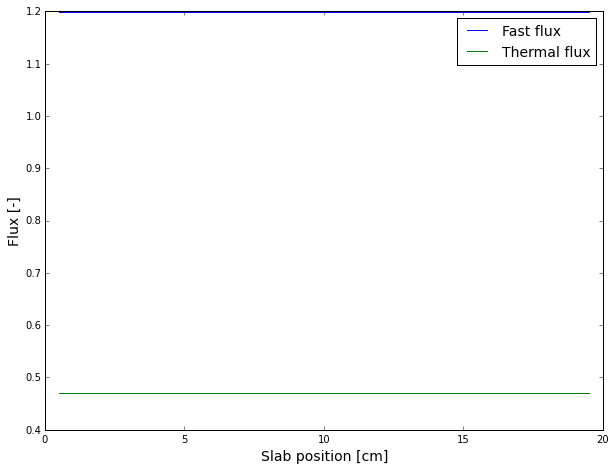

In [7]:
fig, ax = plt.subplots(figsize=(10, 7.5))

ax.plot(slab_x, fluxes[0,:,0], label="Fast flux")
ax.plot(slab_x, fluxes[1,:,0], label="Thermal flux")
ax.set_xlabel("Slab position [cm]", fontsize=14)
ax.set_ylabel("Flux [-]", fontsize=14)
ax.legend(fontsize=14)

The Diffusion Equations for this 1-D Homogeneous slab problem is:

Fast Group Balance: $\Sigma_{t_1}\phi_1 = \Sigma_{s_{1\rightarrow 1}}\phi_1 + \frac{1}{k}\left(\nu\Sigma_{f_1}\phi_1 + \nu\Sigma_{f_2}\phi_2\right)$

Thermal Group Balance: $\Sigma_{t_2}\phi_2 = \Sigma_{s_{1\rightarrow 2}}\phi_1 + \Sigma_{s_{2\rightarrow 2}}\phi_2$

The fast-to-thermal flux ratio can be determined from the thermal group equation:

$\frac{\phi_1}{\phi_2} = \frac{\Sigma_{t_2} - \Sigma_{s_{2\rightarrow 2}}}{\Sigma_{s_{1\rightarrow 2}}}$

In [19]:
# extract data
total_2 = fuel_low.total[1]
scattering_2_2 = fuel_low.scattering[1, 1]
scattering_1_2 = fuel_low.scattering[0, 1]

# flux ratio from cross sections
flux_ratio_xs = (total_2 - scattering_2_2) / scattering_1_2

# flux ratio from solution
flux_ratio_solver = fluxes[0, :, 0] / fluxes[1, :, 0]

print flux_ratio_xs
print flux_ratio_solver

2.54680159017
[ 2.54680159  2.54680159  2.54680159  2.54680159  2.54680159  2.54680159
  2.54680159  2.54680159  2.54680159  2.54680159  2.54680159  2.54680159
  2.54680159  2.54680159  2.54680159  2.54680159  2.54680159  2.54680159
  2.54680159  2.54680159]


The flux ratio can be substituted into the fast group equation:

$\Sigma_{t_1} = \Sigma_{s_{1\rightarrow 1}} + \frac{1}{k}\left(\nu\Sigma_{f_1} + \nu\Sigma_{f_2}\frac{\phi_2}{\phi_1}\right)$

$\Sigma_{t_1} = \Sigma_{s_{1\rightarrow 1}} + \frac{1}{k}\left(\nu\Sigma_{f_1} + \nu\Sigma_{f_2}\frac{\Sigma_{s_{1\rightarrow 2}}}{\Sigma_{t_2} - \Sigma_{s_{2\rightarrow 2}}}\right)$

$k = \frac{\nu\Sigma_{f_1} + \nu\Sigma_{f_2}\frac{\Sigma_{s_{1\rightarrow 2}}}{\Sigma_{t_2} - \Sigma_{s_{2\rightarrow 2}}}}{\Sigma_{t_1} - \Sigma_{s_{1\rightarrow 1}}}$

$k = \frac{\nu\Sigma_{f_1}}{\Sigma_{t_1} - \Sigma_{s_{1\rightarrow 1}}} + \nu\Sigma_{f_2}\frac{\Sigma_{s_{1\rightarrow 2}}}{\left(\Sigma_{t_2} - \Sigma_{s_{2\rightarrow 2}}\right)\left(\Sigma_{t_1} - \Sigma_{s_{1\rightarrow 1}}\right)}$

$k = \frac{\nu\Sigma_{f_1}}{\Sigma_{r_1}} + \nu\Sigma_{f_2}\frac{\Sigma_{s_{1\rightarrow 2}}}{\Sigma_{r_2}\Sigma_{r_1}}$

In [20]:
# extract data
nu_fission_1 = fuel_low.nu_fission[0]
nu_fission_2 = fuel_low.nu_fission[1]
removal_1 = fuel_low.total[0] - fuel_low.scattering[0, 0]
removal_2 = fuel_low.total[1] - fuel_low.scattering[1, 1]
scattering_1_2 = fuel_low.scattering[0, 1]

# k-infinity from equation
k_inf_eq = nu_fission_1 / removal_1 + nu_fission_2*scattering_1_2 / (removal_1 * removal_2)

# k-infinity from calculation
k_inf_calc = eigs[0]

print k_inf_eq
print k_inf_calc

1.10961899195
1.10961899195


Apply zero flux boundary conditions, recalculate and plot

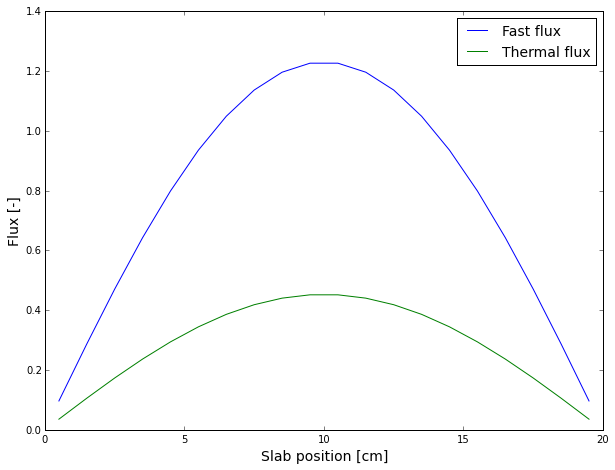

In [24]:
mesh.left_boundary = "zero"
mesh.right_boundary = "zero"

solver = diffusion.Solver(materials, mesh)
solver.solve()

eigs = solver.extract_eigenvalues()
slab_x, fluxes = solver.extract_eigenvectors()

fig, ax = plt.subplots(figsize=(10, 7.5))

ax.plot(slab_x, fluxes[0,:,0], label="Fast flux")
ax.plot(slab_x, fluxes[1,:,0], label="Thermal flux")
ax.set_xlabel("Slab position [cm]", fontsize=14)
ax.set_ylabel("Flux [-]", fontsize=14)
ax.legend(fontsize=14)

What is the k-effective and how does it compare to k-infinity? Why is this?

In [25]:
print "k-infinity = ", k_inf_calc
print "k-effective = ", eigs[0]

print "k-effective < k-infinity? ", eigs[0] < k_inf_calc

k-infinity =  1.10961899195
k-effective =  0.553152646047
k-effective < k-infinity?  True


## Part 2: Cross Section Collapse

You need to collapse the cross sections for the low-enriched fuel from 2 group to 1 group.

In [34]:
# extract data
total_1 = fuel_low.total[0]
total_2 = fuel_low.total[1]
scattering_1_1 = fuel_low.scattering[0, 0]
scattering_1_2 = fuel_low.scattering[0, 1]
scattering_2_1 = fuel_low.scattering[1, 0]
scattering_2_2 = fuel_low.scattering[1, 1]
nu_fission_1 = fuel_low.nu_fission[0]
nu_fission_2 = fuel_low.nu_fission[1]

# collapse xs
total = (total_1*flux_ratio_xs + total_2) / (1 + flux_ratio_xs)
scattering = ((scattering_1_1 + scattering_1_2)*flux_ratio_xs + (scattering_2_1 + scattering_2_2)) / (1 + flux_ratio_xs)
nu_fission = (nu_fission_1*flux_ratio_xs + nu_fission_2) / (1 + flux_ratio_xs)

print "Total: ", total
print "Scattering: ", scattering
print "Nu-fission: ", nu_fission

Total:  0.0946296603831
Scattering:  0.0696046963521
Nu-fission:  0.0277681753617


Calculate k-infinity with these one group cross sections and compare to two-group cross sections. What do you notice and why?

In [35]:
# calculate k-infinity with these one group cross sections
k_inf = nu_fission / (total - scattering)

print k_inf

1.10961899195


Create a material with one energy group for fuel with diffusion coefficient of 1.1

In [40]:
fuel = diffusion.Material(num_energy_groups=1)
fuel.diffusion = [1.1]
fuel.total = [total]
fuel.scattering = [[scattering]]
fuel.nu_fission = [nu_fission]
fuel.chi = [1.0]

## Fuel-Reflector Problem

Assume one group xs for reflector are:

In [81]:
refl = diffusion.Material(num_energy_groups=1)
refl.diffusion = [1.3]
refl.total = [0.1]
refl.scattering = [[0.095]]
refl.nu_fission = [0.0]
refl.chi = [1.0]

Create a slab reactor that is critical with your fuel material. Assume zero flux boundary conditions.

In [104]:
critical_bare = 62.90886

# Create materials
materials = diffusion.Materials(num_materials=1, num_energy_groups=1)
materials.set_material(fuel, 0)

# Create mesh
mesh = diffusion.Mesh(num_parts=1)
mesh.material_map = [0]
mesh.part_sizes = [critical_bare]
mesh.part_mesh = [2000]
mesh.left_boundary = "zero"
mesh.right_boundary = "zero"

# Create solver
solver = diffusion.Solver(materials, mesh)
solver.solve()

# Extract results
eigs = solver.extract_eigenvalues()
slab_x, fluxes = solver.extract_eigenvectors()

print "Critical Eigenvalue = ", eigs[0]

Critical Eigenvalue =  0.999997851545


Determine the reflector savings with an infinite reflector let's say 100 cm on each side. How does it compare with theoretical derivation?

In [105]:
critical_refl = 35.759

# Create materials
materials = diffusion.Materials(num_materials=2, num_energy_groups=1)
materials.set_material(fuel, 0)
materials.set_material(refl, 1)

# Create mesh
mesh = diffusion.Mesh(num_parts=3)
mesh.material_map = [1, 0, 1]
mesh.part_sizes = [100.0, critical_refl, 100.0]
mesh.part_mesh = [2000, 2000, 2000]
mesh.left_boundary = "zero"
mesh.right_boundary = "zero"

# Create solver
solver = diffusion.Solver(materials, mesh)
solver.solve()

# Extract results
eigs = solver.extract_eigenvalues()
slab_x, fluxes = solver.extract_eigenvectors()

print "Critical Eigenvalue = ", eigs[0]

Critical Eigenvalue =  0.999999008913


In [109]:
reflector_savings_calc = critical_bare - critical_refl
print reflector_savings_calc

27.14986


Calculate theoretical

In [116]:
# Calculate diffusion length of reflector
L_r = np.sqrt(refl.diffusion[0] / (refl.total[0] - refl.scattering[0]))
print fuel.diffusion[0] / refl.diffusion[0] * L_r * 2

[ 27.28764161]


Perform and plot the 2 group solution for fuel_low and reflector materials with critical reflected dimensions above
(result wont be exactly critical because reflector cross sections are different in 2 groups)

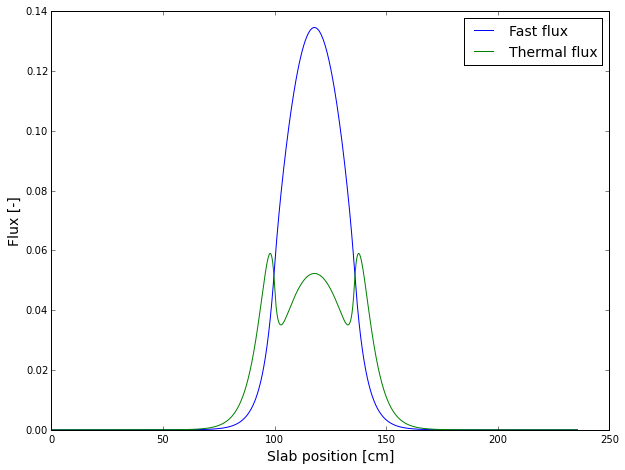

In [120]:
# Create materials
materials = diffusion.Materials(num_materials=2, num_energy_groups=2)
materials.set_material(fuel_low, 0)
materials.set_material(reflector, 1)

# Create mesh
mesh = diffusion.Mesh(num_parts=3)
mesh.material_map = [1, 0, 1]
mesh.part_sizes = [100.0, critical_refl, 100.0]
mesh.part_mesh = [2000, 2000, 2000]
mesh.left_boundary = "zero"
mesh.right_boundary = "zero"

# Create solver
solver = diffusion.Solver(materials, mesh)
solver.solve()

# Extract results
eigs = solver.extract_eigenvalues()
slab_x, fluxes = solver.extract_eigenvectors()

# Plot results
fig, ax = plt.subplots(figsize=(10, 7.5))

ax.plot(slab_x, fluxes[0,:,0], label="Fast flux")
ax.plot(slab_x, fluxes[1,:,0], label="Thermal flux")
ax.set_xlabel("Slab position [cm]", fontsize=14)
ax.set_ylabel("Flux [-]", fontsize=14)
ax.legend(fontsize=14)

## Reactor Design

[ 3  3 -1  0 -1  0 -1  0 -1  0  1  2  1  2  1  2  1  2  1  3  3]


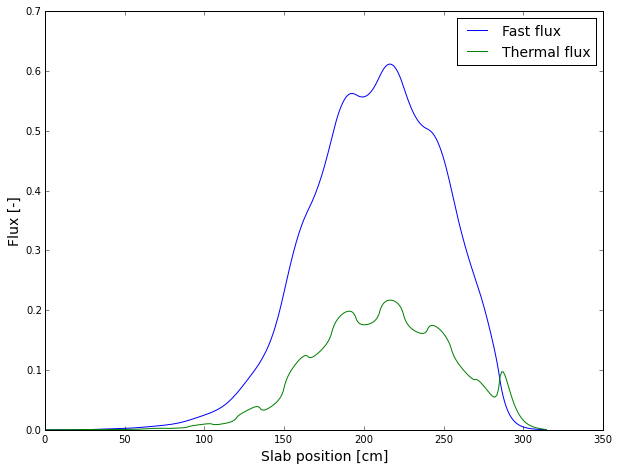

In [126]:
materials = diffusion.Materials(num_materials=5, num_energy_groups=2)
materials.set_material(fuel_low, 0)
materials.set_material(fuel_low_rod, 1)
materials.set_material(fuel_high, 2)
materials.set_material(fuel_high_rod, 3)
materials.set_material(reflector, 4)

mesh = diffusion.Mesh(num_parts=21)
mesh.material_map = [4, 4, 0, 1, 0, 1, 0, 1, 0, 1, 2, 3, 2, 3, 2, 3, 2, 3, 2, 4, 4]
print np.array(mesh.material_map) - 1
mesh.part_sizes = 21*[15.0]
mesh.part_mesh = 21*[15]
mesh.left_boundary = "vacuum"
mesh.right_boundary = "vacuum"

solver = diffusion.Solver(materials, mesh)
solver.solve()

eigs = solver.extract_eigenvalues()
slab_x, fluxes = solver.extract_eigenvectors()

fig, ax = plt.subplots(figsize=(10, 7.5))

ax.plot(slab_x, fluxes[0,:,0], label="Fast flux")
ax.plot(slab_x, fluxes[1,:,0], label="Thermal flux")
ax.set_xlabel("Slab position [cm]", fontsize=14)
ax.set_ylabel("Flux [-]", fontsize=14)
ax.legend(fontsize=14)